## Authenticate and create PyDrive client.

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html


## Import data

In [0]:
import pandas as pd
import io
import numpy as np
from scipy.sparse import csr_matrix
import scipy
import scipy.sparse
import random

In [3]:

file_list = drive.ListFile({'q': "'1j8oG_vCmum9YuVWP8LdbSkfj-lfi-AZ0' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: training_desc.csv, id: 1kSoeoaK_TsTHnhSGPXOLNy43jd20G8bH
title: training_data.csv, id: 12-B9GpferXatOB4ACo7GanQ2iBt5O-66
title: test_data.csv, id: 1y_YySFyibYYwQtJr6v7Qf81FqULwK7Fk
title: training_labels.csv, id: 1cqErOBjBB91P_xrt4TKuZ91OfTLoUYmx


### Pulling data into Google Colab.

In [0]:
#@title Default title text
training_data_downloaded = drive.CreateFile({'id': '12-B9GpferXatOB4ACo7GanQ2iBt5O-66'})
training_data_downloaded.GetContentFile('training_data.csv')

#training_desc_downloaded = drive.CreateFile({'id': '1kSoeoaK_TsTHnhSGPXOLNy43jd20G8bH'})
#training_desc_downloaded.GetContentFile('training_desc.csv')

training_labels_downloaded = drive.CreateFile({'id': '1cqErOBjBB91P_xrt4TKuZ91OfTLoUYmx'})
training_labels_downloaded.GetContentFile('training_labels.csv')

#test_data_downloaded = drive.CreateFile({'id': '1y_YySFyibYYwQtJr6v7Qf81FqULwK7Fk'})
#test_data_downloaded.GetContentFile('test_data.csv') 

### Load data files
(example:)

In [0]:
def data_loader():
  traindata = pd.read_csv('training_data.csv', header=None).sort_values([0])
  # df_desc = pd.read_csv('training_desc.csv')
  trainlabel = pd.read_csv('training_labels.csv', header=None).sort_values([0])
  # df_test = pd.read_csv('test_data.csv')
  #@title Default title text
  variable_name = 0 #@param {type:"raw"}
  traindata = traindata.drop(0, 1)
  trainlabel = trainlabel.drop(0, 1)

  traindata = csr_matrix(traindata.values)
  labels, trainlabel = np.unique(trainlabel, return_inverse = True)
  return traindata, trainlabel, labels

traindata, trainlabel, labels = data_loader()



---


In [0]:
class OneHotEncoding(object):
    
    def transform(Y):
        labels = []
        numclass = len(np.unique(Y))
        for value in Y:
            classes = [0 for _ in range(numclass)]
            classes[value] = 1
            labels.append(classes)
        return np.array(labels)
    
    def inverse_transform(Y):
        return np.argmax(Y, axis = 1)
      
#Y = OneHotEncoding.transform(trainlabel)

This project aims to experiment different machine learning methodologies to solve a text classification problem. Given a fixed set of classes and a training set of labelled documents, we seek to learn a classifier that maps documents to classes. The documents are represented by some high dimensional space, where each dimension represents a word and the TF-IDF value in that column is a numerical statistic to estimate the importance of that word to a document with respect to the collection of documents (Schütze, & Raghavan, 2008). In order to build the classifier, the training documents are split into a training and a validation set. The training set provides typical examples for the classifier to learn, while the validation set is used to tune the classifier. The goal of the classifier is to achieve high accuracy on a testing set of documents. This is a supervised learning process because the training documents are served as a "supervisor" to direct the modelling. Two supervised learning methodologies have been chosen to build the classifier: multinominal naïve bayes and multinomial logistic regression. We are interested in exploring the characteristic of these types of classifiers and to compare their performance. Additionally, we are also interested in studying other methods to leverage the performance of our classifiers. One method is to build an ensemble model on top of the multinominal naïve bayes classifiers and the multinomial logistic regression classifiers. Another is to experiment with some feature reduction techniques to improve learning efficiency and avoid overfitting.   

## 1. Multinomial Naïve Bayes Classifier
Naïve Bayes classifier has been a popular method to solve text classification problem since the early 1960s (Russell, 2016). It is a probabilistic learning model based on Bayes' theorem. In Bayes' theorem, the probability of an event A occurring under the condition of event B is determined by three elements: some prior knowledge about event A, the likelihood of event B occurring under the condition of event A occurring, and the probability of event B occurring (Lewis, 1998). Here is the formula: 

**P(A|B) = (P(B|A)XP(A)) / P(B)**

In a text classification problem, our goal is to find the class c that a document d has the highest probability belonging to. The conditional probability of a document d belonging to a class c can be denoted as P(c|d). Given a document d and a set of possible classes c=c1, c2, …, ck, the Multinomial Naïve Bayes classifier returns the class that has the highest P(c|d) as the prediction. P(c|d) is calculated following the Bayes' theorem:

**MNB_Prediction = argmax_c{P(c|d)}**

**= argmax_c{P(d|c)XP(c) / P(d)}** --following Bayes' Theorem

**= argmax_c{P(d|c)XP(c)}** --P(d) can be ignored because it is not related to c

In the above formula, P(d|c) is the likelihood of a document d occurring in class c. Multinomial Naïve Bayes classifier makes some 'naive' assumption and simplification to calculate this probability. It treats the distribution of words in the documents as a multinomial, and it assumes that the occurrences of words are independent from each other (Rennie et al., 2003). Under this assumption, P(d|c) can be calculated from the joint probability of P(w1|c), P(w2|c), …, P(wn|c), where w1, w2, …, wn are all unique words in the documents:

**P(d|c) = P(w1|c)XP(w2|c)…XP(wn|c)**

Now, we have MNB_Prediction = argmax_c{P(c)*P(w1|c)*P(w2|c)…*P(wn|c)}.  
From this equation, there is an obvious problem to be observed. In practice, we usually have a very large space of unique words. This leads to multiplying lots of conditional probabilities together and results in a very small value with floating point overflow. According to Schütze, Manning, and Raghavan (2008), log transformation can be applied to solve this problem:

**MNB_Prediction = argmax_c{logP(c) + logP(w1|c) + logP(w2|c)…+ logP(wn|c)}**

Given a training set of documents d and their labelling classes, the multinomial naïve bayes classifier will learn the prior knowledge of each classes P(c), where c=c1, c2, …, ck; and the likelihood P(w|c) for all unique words in the word space w=w1, w2, …, wn. P(c) can be easily calculated by counting the occurrence of the training documents in class c, divided by the total occurrence of training documents: 

**P(c) = Count(training documents in class c) / Count(all training documents)**

P(wi|c) can be calculated by counting the occurrence of word wi in training documents of class c, divided by the total occurrence of words in the training documents of class c. In this project, the word occurrence is represented by the tf-idf value. Let T_wi_c denotes the sum of the tf-idf value of word w in documents of class c, we can calculate P(w|c) as follows:

**P(wi|c) = T_wi_c / (T_w1_c + T_w2_c + … + T_wn_c) = T_wi_c / Sum(T_w_c)**

However, in practice, not every unique word appears in all of the classes, which means that we will have P(w|c) equals to 0 for unseen words in class c. In this case, logP(c) + logP(w1|c) + logP(w2|c)…+ logP(wn|c) will always be negative infinity for all classes c. Laplacian smoothing can be used to solve this problem by shifting some small positive probability to unseen words (Schütze, Manning, & Raghavan, 2008). Let alpha be a parameter to control how much positive probability we want to shift, |W| denotes the number of unique words in the word space, we transform the formula with laplacian smoothing as follow: 

**P(wi|c) = (T_wi_c + alpha) / (Sum(T_w_c) + |W|)**

After learning the prior knowledge P(c) and the likelihood P(wi|c) from the training documents, the multinomial naïve bayes classifier can predict the best class for a new document d_new (from the validation or testing data) based on the following calculation:

**MNB_Prediction = argmax_c{logP(c) + f1XlogP(w1|c) + f2XlogP(w2|c)…+ fnXlogP(wn|c)}**

where f1, f2, …, fn denotes the word frequency of w1, w2, …, wn in d_new, which are the tf-idf values in this project. 

## 2. Multinomial Logistic Regression Classifier

Multinomial Logistic regression, also known as softmax regression and maximum entropy classifier, is a supervised learning method that can be used in multiclass classification problems. It is very similar to logistic regression except for the fact that the outcomes of the model, which can be seen as a categorical dependent variable, is multivalued instead of binary (Vryniotis, 2013). Statistically speaking, multinomial logistic regression is a predictive analysis that predicts the dependent categorical variable from a set of independent variables (Vryniotis, 2013). The model learns the relationship between the dependent variable and the independent variables from some sample data. In a text classification problem, a document can be seen as a data sample, the dependent variable is the class that a document belonging to, and the independent variables are the occurrence of words in the document word space. 
Like logistic regression, in order to predict the outcomes from the independent variables, the model assumes there is a linear relationship in between the outcome and the independent variables (Vryniotis, 2013). Let c denotes the possible classes that a document can belong to, d denotes a document, f(c, d) denotes the probability of a document d belonging to class c. In the text classification problem, multinomial logistic regression assumes f(c, d) has a linear relationship with the occurrence of the words w1, w2, w3, …, wn:

**f(c, d) = b0,c + b1,c X w1,d + b2,c X w2,d +…+ bn,c X wn,d**

As we can see from the above equation, so far f(c, d) is not a legal probability. The sum b0,c + b1,c X w1,d' + b2,c X w2,d' +…+ bn,c X wn,d' produce values from negative infinity to positive infinity instead 0 to 1. According to Martin(2009), this can be easily solved by wrapping up the sum with a softmax function:

**f(c, d) = exp(Bc∙Xd) / (Sum(exp(Bc'∙Xd)))**

where Bc = b0,c, b1,c, b2,c, …+ bn, c is a set of coefficients to parameterize the relationship, Xd is a vector of wj,d, and wj,d is the tf-idf value of word j in a given document d. 

Bc is unique for each class and they are learnt by the model from some training data. After Bc is learnt, they are used to predict the best class for a given document d'

**MLR_Prediction = argmax_c(f(c, d'))** 

For our specific multinomial logistic regression, we use mini-batch stochastic gradient descent to optimise our weights, updating them to minimise our cost function output. The cost function in multionomial Logistic Regression is categorical cross entropy:

**cost = -sum(y*log(p))**

where y is the true label value and p is the prediction probability.

One advantage of multinomial logistic regression classifier over multinomial naïve bayes classifiers is that the model does not need to assume statistical independence between the independent variables, which are the occurrence of words in the text classification problem (Martin, 2009). Preserving the dependent relationship between words can potentially give us a better prediction result. However, multinomial logistic regression requires a much larger timeframe to be trained compared to multinomial naïve bayes classifier. This is due to its iterative nature to estimate the parameters of the model (Vryniotis, 2013).

## 3. Ensemble Learning

Ensemble learning is a technique that combines individually trained base models into one predictive model in order to improve prediction result (Opitz, 1999). Both empirical and theoretical research has proved that the combined model, which is usually called an ensemble, generally outperforms any of the individual base models making up the ensemble (Opitz, 1999). 
In this project, we first designed a simple cross validation ensemble model. In cross validation, the training dataset is split into k folds with one of them as the validation fold, and the other k-1 folds as the training folds. We build naïve bayes and logistic regression classifiers respectively at each training folds and average their prediction results. It is hypothesised that this ensemble model will give better prediction results due to following reasons: the stronger base classifier can pull up the performance of the weaker base classifier; avoid learning bias from a specific subset of data; instead of using sampling method to obtain data subsets, using the cross-validation folds can ensure the model makes the most use of the training data.  
Additionally, we also considered a widely known ensemble method to leverage our naïve bayes classifier and logistic regression classifier: bagging. Bagging reduces the variance and bias of the prediction by averaging the results returned from multiple base models (Smolyakov, 2017). These base models are trained independently on different subsets of the training data, which are obtained via bootstrap sampling (sample randomly with replacement) from the original dataset (Smolyakov, 2017). It is usually effective on base models that are less stable, especially the one with high sensitivity to perturbation on training data (Dietterich, 2000).    


### Pre-processing 

With the code below, the following data pre-processing methods have been experimented 

1. scale the data with standard deviaiton
2. fold change for feature reduction
3. PCA for feature reduction
4. elimilating words with low tf-idf values

In [0]:
##Train Test Split function
def train_test_split(X, Y, X_size = 19000, random_state = 1):
    '''X_size specifies number of rows in training data'''
    idx = np.random.RandomState(seed=random_state).permutation(X.shape[0])
    trainsplit = idx[:X_size]
    testsplit = idx[X_size:]
    return X[trainsplit], Y[trainsplit], X[testsplit], Y[testsplit]

In [0]:
class FeatureReduction(object):
    '''Input X and Y where X is in a sparse matrix'''
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y
        XY = scipy.sparse.hstack((Y.reshape(X.shape[0],1),X))
        self.XY = pd.DataFrame(XY.toarray())
    
    def StandardDeviationFR(self, nfeatures = 10000):
        means = self.XY.groupby(0).mean()
        std = np.std(means, axis=0)
        self.std = std
        
        index = std.sort_values(ascending=False)[:nfeatures].index
        index = np.r_[index]
        index -= 1
        self.index = index
        return index, std
    
    def FoldChange(self, nfeatures = 10000):
        '''Calculates Fold change'''
        data = self.XY + 1e-8
        output= []
        for i in range(data.shape[0]):
            fold_change = []
            for j in range(data.shape[0]):
                fld_chng = np.abs(np.log2(data.iloc[i, 1:] / data.iloc[j, 1:]).values)
                fold_change.append(fld_chng)
            output.append(fold_change)
        output = np.array(output)
        total = []
        for i in range(output.shape[0]):
            mean = np.mean(output[i], axis=0)
            total.append(mean)
            
        final = pd.Series(np.mean(total, axis = 0))
        self.final = final
        index_fld = final.sort_values(ascending=False)[:nfeatures].index
        index = np.r_[index_fld]
        index -= 1
        self.index = index
        return index, final
    
    def Occurence(self, nfeatures = 10000, method = 'Count'):
        '''Two methods for ranking feature occurrence. Raw counts through Count or
        summed feature wise sum of tf-idf values via Sum'''
        if method  == 'Count':
            counts = pd.DataFrame(self.X.getnnz(axis=0))
            countssort = counts.sort_values(0, ascending = False)
            self.occur = countssort
            index = countssort[:nfeatures].index
            index = np.r_[index]
            self.index = index
            return index, countssort
        elif method =='Sum':
            sums = pd.DataFrame(self.X.sum(axis = 0).T)
            sumssort = sums.sort_values(0, ascending = False)
            self.occur = sumssort
            index = sumssort[:nfeatures].index
            index = np.r_[index]
            self.index = index
            return index, sumssort

    def transform(self, X):
        '''Returns the dataset with reduced features'''
        return X[:,self.index]

from scipy.sparse.linalg import svds

class PCA(object):
    """Computes a reconstructed matrix from the SVD decomposition of a n*p matrix. Not technically a PCA as we do not centre/normalize data.
    Reason we do not scale is because it will defeat the purpose of a sparse matrix and increase the computing time. 
    """
    def __init__(self, components = 10):
        self.components = components
        
    def fit(self, X):       
        u, s, vt = svds(X, k = self.components)
        S = np.diag(s[::-1])
        n = len(s)
        self.u = u[:,n-1::-1]
        self.S = S
        self.vt = vt[n-1::-1,:]
        
    def transform(self, X):
        u = self.u
        S = self.S
        components = self.components
        X_r = u[:,0:components].dot(S[0:components,0:components])
        return X_r

    def fit_transform(self,X):        
        components = self.components
        u, s, vt = svds(X, k = self.components)
        S = np.diag(s[::-1])
        n = len(s)
        self.u = u[:,n-1::-1]
        self.S = S
        X_r = u[:,0:components].dot(S[0:components,0:components])
        return X_r


    

### Classifier

In [0]:
import numpy as np
from scipy.sparse import csr_matrix

"""Multinomial Logistic Regression Classifier
:type lr: numeric
:param lr: the learning rate that gradient descent is performed, default to 1

:type n_iter: integer
:param n_iter: the number of iterations to perform gradient descent, default to 100

:type C: numeric
:param C: the l2 regularization coefficient, defaults to 0.1

:type SGD: boolean
:param SGD: defines whether SGD is used or not. If false then standard batch gradient descent is used, defaults to True

"""
class MultinomialLogisticRegression(object):
    def __init__(self, lr = 1, n_iter = 100, C = 0.1, SGD = True):
        #Initialises the parameters
        self.lr = lr
        self.n_iter = n_iter
        self.C = C
        self.SGD = SGD
        
    def fit(self, X, Y, batchsize = 218):
        #fits the model to a dataset. Batchsize is a term that must be specified when using SGD. If not SGD it can be left as it is.
        self.N = X.shape[0]
        #if label shape is not dummy encoded then we dummy encode in the function
        if Y.shape == (X.shape[0],):
            Y = OneHotEncoding.transform(Y)
        #Initialises the weights and bias to zeros
        #self.weights = np.random.normal(0,2/(X.shape[1] + Y.shape[1]),(X.shape[1], Y.shape[1]))
        self.weights = np.zeros((X.shape[1],Y.shape[1]))
        self.bias = np.zeros((1,Y.shape[1]))
        
        #Iteration loop
        for i in range(self.n_iter):  
            #Saving costs and accuracy
            costs = []
            accuracy = []
            #SGD
            if self.SGD:
                #split into batches
                batchXY = zip([X[i:i+batchsize,:] for i in range(0,X.shape[0],batchsize)],
                              [Y[i:i+batchsize,:] for i in range(0,Y.shape[0],batchsize)])
                for batchX, batchY in batchXY:
                    #Regularisation 
                    self.reg = self.C/(2*batchX.shape[0]) * np.sum(self.weights**2)
                    #Get prediction output
                    Ypred = self.output(batchX)
                    #Get cost
                    self.cost = self.cross_entropy(Ypred, batchY) + self.reg
                    #Get accuracy
                    acc = LR_get_accuracy(Ypred, batchY)
                    #Get gradient of error
                    costgrad = self.cost_grad(batchY)
                    #Calculate gradient of parameters from error grad
                    dweight, dbias = self.param_grad(batchX, costgrad)
                    #Update parameters
                    self.weights += -self.lr * dweight - (self.lr * ((self.C/batchX.shape[0])*self.weights))
                    self.bias += -self.lr * dbias
                    accuracy.append(acc)
                    costs.append(self.cost)
            #BatchGradientDescent
            else:
                self.reg = self.C/(2*X.shape[0]) * np.sum(self.weights**2)
                Ypred = self.output(X)
                self.cost = self.cross_entropy(Ypred, Y) + self.reg
                acc = LR_get_accuracy(Ypred, Y)
                costgrad = self.cost_grad(Y)
                dweight, dbias = self.param_grad(X, costgrad)
                self.weights += -self.lr * dweight - (self.lr * ((self.C/X.shape[0])*self.weights))
                self.bias += -self.lr * dbias
                accuracy.append(acc)
                costs.append(self.cost)   
            #print('Iteration:', i, '\nAccuracy:', accuracy[-1], '\nCost:', costs[-1])
                
    def softmax(self, x):
        #Softmax function for multinomial logistic regression. Makes probability sum to 1
        #We subtract the max of x from x to prevent numeric overflow
        e_x = np.exp(x - np.max(x, axis = -1, keepdims= True))
        return e_x / np.sum(e_x, axis = -1, keepdims = True)
    
    def output(self, X):
        #Calculates an output from input and parameters
        self.out = self.softmax(X.dot(self.weights) + self.bias)
        return self.out
    
    def param_grad(self, X, output_grad):
        #Calculates the gradient of the parameters
        dW = X.T.dot(output_grad)
        dB = np.sum(output_grad, axis = 0, keepdims = True)
        return dW, dB
    
    def cost_grad(self, T):
        #Calculates the gradient of the cost
        self.costgrad = (self.out-T)/self.out.shape[0]
        return self.costgrad
    
    def cross_entropy(self, output,label,epsilon = 1e-12):
        #Calculates the loss. We clip the output value by an epsilon term to preserve numeric stability. No zero outputs
        output = np.clip(output, epsilon, 1. -epsilon)
        m = label.shape[0]
        log_likelihood = np.log(output)
        loss = -np.sum(label*log_likelihood) / m
        return loss
    
    def predict(self, X):
        #A predict function that does the same thing as output but for test data.
        out = self.softmax(X.dot(self.weights) + self.bias)
        return out

In [0]:
import pandas as pd
import io
import numpy as np
from scipy.sparse import csr_matrix
import random

"""Multinomial Naive Bayes Classifier
:type alpha: float
:param alpha: laplace smoothing parameter, default to 0.01

:type cv: integer
:param cv: if cv>1, the model will run with cross validation, the value of cv is the number of fold to split; 
when cv=1, the model run without cross validation, default to 1. If cv=0 then we specify the input training and test data ourselves.

In order to save memory, we wrapp data reading inside the Naive Bayes Classifier.
Data are read and split automatically when the model.fit() function is call

When run in cross validation mode, the predict function will return a list of K
fold predictions; self.testlabel will be stored as a list of k fold labels

"""
class MultinomialNaiveBayes(object):
    
    def __init__(self, alpha=0.01, cv=1):
      # wrap reading data here if run out of memory
      self.alpha = alpha
      self.cv = cv
      if cv>1:
        # record prediction result for cross validation
        self.cv_pred = []
        # record test labels for each fold
        self.cv_test_labels = []
       
    def kfold_split(self, nrow, random_state=0):
      k=self.cv
      # Set random Seed
      random.seed(random_state)
      # Size per fold
      fold_size = int(nrow/k)
      # Return a list of k arrays of size=Fold_Size without replacement
      cv_index = np.random.choice(nrow, size=(k, fold_size), replace=False)
      return cv_index
    
    def fit_fold(self, X):       
      # P(C)
      class_prob = X.iloc[:,0].value_counts()
      class_prob = class_prob/np.sum(class_prob)
      # log(p(w|C))
      class_prob_log = np.log(class_prob)
      # sort index thus it has the same sequence as the others
      self.class_prob_log = class_prob_log.sort_index()
      term_prob = X.groupby("class").sum() 
      #flash out X
      X=None
      # count(wi, Ci) + alpha
      term_prob = term_prob + self.alpha
      
      #Sum_wi(P(wi|C))+alpha*number_of_features/words
      deno=term_prob.sum(axis=1)+self.alpha*term_prob.shape[1]
      # p(w|C)
      wc_prob = term_prob.div(deno, axis=0)
      # store the index of the class for wc matirx
      class_index = wc_prob.index
      # log(p(w|C)), negative infinity log(0) is turned to 0
      self.wc_prob_log = csr_matrix(np.log(wc_prob).replace(-np.inf, 0.0)) 
    
    def predict_fold(self):
      # Sum(fi*log(P(wi|Ci)))
      # fi is the tf-idf value of wi in test data
      # each row represents an app
      # each column represents the Sum(fi*log(P(wi|Ci))) value for a class
      likelihood_matrix = self.testdata.dot(self.wc_prob_log.transpose()).toarray()
      index=0
      pred = []
      probs = []
      for likelihood_log in likelihood_matrix:
        prob_log = likelihood_log + self.class_prob_log
        #print(prob_log)
        probs.append(prob_log)
        predicted_label = prob_log.idxmax()   
        pred.append(predicted_label)
        index = index + 1   
      return pred, probs
    
    def fit(self, X = None, Y = None, testX = None, testY = None, preload = True):
      if preload:
          #pre-processing data
          traindata = pd.read_csv('training_data.csv', header=None).sort_values([0])
          trainlabel = pd.read_csv('training_labels.csv', header=None).sort_values([0])
          variable_name = 0
          traindata = traindata.drop(0, 1)
          trainlabel = trainlabel.drop(0, 1)
          labels, trainlabel = np.unique(trainlabel, return_inverse = True)
          traindata.insert(loc=0, column="class", value=trainlabel)  
          print("Finish reading the data...")
      else:
          trainlabel = pd.DataFrame(Y)
          traindata = pd.DataFrame(X.toarray())
          traindata.insert(loc=0, column="class", value=trainlabel)
          
      #If no cv used, we make the split outside the class.
      if self.cv==0:
          testdata = pd.DataFrame(testX.toarray())
          self.testdata = testdata
          self.testdata = self.testdata.reset_index(drop=True)
          self.testdata = csr_matrix(self.testdata) 
          # fit the model
          self.fit_fold(traindata)
          
      # if it is not cross validation
      if self.cv==1:
        # spliting
        split_index=int(traindata.shape[0]*.9)
        self.testdata = traindata[split_index:]
        self.testdata = self.testdata.reset_index(drop=True)
        self.testdata = self.testdata.drop(["class"], axis=1)
        self.testlabel = trainlabel[split_index:] 
        # turn testing data to a csr_matrix
        self.testdata = csr_matrix(self.testdata) 
        traindata = traindata[:split_index]
        # fit the model
        self.fit_fold(traindata)
       
      #if it is cross validation
      if self.cv>1:
        cv_index = self.kfold_split(traindata.shape[0])
        # for each fold train and predict
        for fold_number, fold_index in enumerate(cv_index):
          print("Training on"+str(fold_number)+" fold now...")
          test_index = fold_index
          train_index = [i for i in range(traindata.shape[0]) if i not in fold_index]
          # getting k fold data    
          self.testdata, testlabel = traindata.iloc[test_index, :], trainlabel[test_index]
          self.testdata = self.testdata.reset_index(drop=True)
          self.testdata = self.testdata.drop(["class"], axis=1)
          self.testdata = csr_matrix(self.testdata)
          training_data = traindata.iloc[train_index, :]
          # record testlabel
          self.cv_test_labels.append(testlabel)
          # fit from model fold
          self.fit_fold(training_data)
          #flashout training data
          training_data=None
          # predict the result
          pred=self.predict_fold()
          self.cv_pred.append(pred)

    def predict(self):  
      # if it is cross validation
      if self.cv>1:
        return self.cv_pred      
      # if it is not cross validation
      if self.cv<1:
        return self.predict_fold()    

    
#modelNB = MultinomialNaiveBayes(alpha=0.01, cv=10)
#modelNB.fit()
#pred=modelNB.predict()
# test
#print(np.sum(pred==modelNB.testlabel)/len(pred))

In [0]:
"""Cross Validation and Model Evaluation"""
def LR_get_accuracy(Y, T):
    t_positive = 0
    for i, j in zip(Y, T):
        predY = np.argmax(i)
        trueY = np.argmax(j)
        if predY == trueY:
            t_positive += 1
    return t_positive / T.shape[0]

def NB_get_accuracy(Y, T):
    '''Feeds in naive bayes prediction and true label list'''
    t_positive = 0
    for i, j in zip(Y, T):
        predY = np.argmax(i)
        if predY == j:
            t_positive += 1
    return t_positive / T.shape[0]
  
def metrics(pred, true, modeltype = 'LR'):
    # Join the true and predicted labels
    if modeltype == 'LR':
      truth, prediction = map(np.argmax, true), map(np.argmax, pred)
    elif modeltype == 'NB':
      truth, prediction = true, map(np.argmax, pred)
    truth, prediction = np.fromiter(truth, dtype=np.int), np.fromiter(prediction, dtype=np.int)
    truth, prediction = truth.reshape(len(truth), 1), prediction.reshape(len(prediction), 1)
    total = np.concatenate((truth, prediction), axis=1)
    class_accuracy = []
    
    for label in range(30):
        true_class_index = total[:, 0] == label
        pred_class_index = total[:, 1] == label
        pred_not_class_index = total[:, 1] != label
        # TP - When the prediction equals the true Label
        TP = np.sum(label == total[true_class_index, 1])
        # FN - When the prediction does not equal the true label
        FN = np.sum(label != total[true_class_index, 1])
        # FP - When the prediction selects the class but it is not true
        FP = np.sum(total[pred_class_index, 0] != label)
        # When the Prediction does not select the class and the truth is not the class
        #TN = np.sum(total[pred_not_class_index, 0] != label)
        accuracy = TP / sum(true_class_index)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = (2 * recall * precision) / (recall + precision)
        class_accuracy.append([label, sum(true_class_index), accuracy, precision, recall, f1_score])
    
    return class_accuracy
  
def metric_table(data):
    summary = pd.DataFrame()
    for i in range(len(data)):
        for j in range(len(data[i])):
            summary = summary.append(pd.Series(data[i][j]), ignore_index=True)
    summary.columns = ['Label', 'Count', 'Accuracy', 'Precision', 'Recall', 'F-Score']
    return summary

def kfold_split(data, k, random_state=0):
    # Set random Seed
    random.seed(random_state)
    # Number of Rows
    nrow = data.shape[0]
    # Size per fold
    fold_size = int(nrow / k)
    # Return a list of k arrays of size=Fold_Size without replacement
    cv_index = np.random.choice(nrow, size=(k, fold_size), replace=False)
    return cv_index


def cross_validation(data, labels, cv_index, model,  batchsize, accuracy_function, modeltype = 'LR'):
    total = []
    accuracy = []
    if modeltype == 'LR':
      for fold_number, fold_index in enumerate(cv_index):
          print('Fold Number:', fold_number)
          test_index = fold_index
          train_index = [i for i in range(traindata.shape[0]) if i not in fold_index]
          X_train, y_train = data[train_index, :], labels[train_index]
          X_val, y_val = data[test_index, :], labels[test_index]
          model.fit(X_train, y_train)
          pred = model.predict(X_val)
          metric = metrics(pred, y_val, modeltype)
          total.append(metric)
          acc = accuracy_function(pred, y_val)
          accuracy.append(acc)
    elif modeltype =='NB':
      for fold_number, fold_index in enumerate(cv_index):
          print('Fold Number:', fold_number)
          test_index = fold_index
          train_index = [i for i in range(traindata.shape[0]) if i not in fold_index]
          X_train, y_train = data[train_index, :], labels[train_index]
          X_val, y_val = data[test_index, :], labels[test_index]
          modelNB = MultinomialNaiveBayes(alpha=0.01, cv=0)
          modelNB.fit(X_train, y_train, X_val, y_val, preload = False)
          pred = np.array(modelNB.predict()[1])
          metric = metrics(pred, y_val, modeltype)
          total.append(metric)
          acc = accuracy_function(pred, y_val)
          accuracy.append(acc)
    output = metric_table(total)
    return output, accuracy

## Baseline

First we create a baseline model. We will do a train-test split and run both models on this data. We will then use feature reduction techniques to gridsearch the best technique and number of features to use.

In [12]:

X_train, y_train, X_val, y_val = train_test_split(traindata, trainlabel)
print(X_train.shape)
print(y_train.shape)

# Runtime - 0.6

(19000, 13626)
(19000,)


In [13]:
##Logistic Regression
modelLR = MultinomialLogisticRegression(lr=20, n_iter = 40, C= 0.001, SGD = True)
modelLR.fit(X_train, y_train, batchsize = 100)
pred = modelLR.predict(X_val)
LR_get_accuracy(pred, OneHotEncoding.transform(y_val)) ##Encode because the y_val is not encoded

# Runtime - 28.8s

0.6557971014492754

In [14]:
##Naive Bayes
modelNB = MultinomialNaiveBayes(alpha=0.01, cv=0)
modelNB.fit(X_train, y_train, X_val, y_val, preload = False)
pred = np.array(modelNB.predict()[1])
NB_get_accuracy(pred, y_val)

# Runtime - 2.8s

0.6331521739130435

### Feature reduction

The Logistic Regression's baseline appears to perform better than the Naive Bayes. We will now use some feature reduction to get more informative features, removing noisy features.

In [15]:
##Using StandardDeviation to get top 10000 features
FR = FeatureReduction(traindata, trainlabel)
idx = FR.StandardDeviationFR(nfeatures = 10000)
X = FR.transform(traindata)

X_train, y_train, X_val, y_val = train_test_split(X, trainlabel)
print(X_train.shape)
print(y_train.shape)

# Runtime - 2.3s

(19000, 10000)
(19000,)


In [16]:
##Logistic Regression
modelLR = MultinomialLogisticRegression(lr=20, n_iter = 40, C= 0.001, SGD = True)
modelLR.fit(X_train, y_train, batchsize = 100)
pred = modelLR.predict(X_val)
LR_get_accuracy(pred, OneHotEncoding.transform(y_val)) ##Encode because the y_val is not encoded

# Runtime - 23.9s

0.6557971014492754

In [17]:
##Naive Bayes
modelNB = MultinomialNaiveBayes(alpha=0.01, cv=0)
modelNB.fit(X_train, y_train, X_val, y_val, preload = False)
pred = np.array(modelNB.predict()[1])
NB_get_accuracy(pred, y_val)

# Runtime - 2.5s

0.6322463768115942

Using StandardDeviation feature reduction, taking only top 10000 features appears to increase our accuracy.
We can try using TF-IDF columnwise sums to rank the features and take 10000 as well.

In [18]:
##Using TF-IDF columnwise sum rankings
FR = FeatureReduction(traindata, trainlabel)
idx = FR.Occurence(nfeatures = 10000, method = 'Sum')
X = FR.transform(traindata)

X_train, y_train, X_val, y_val = train_test_split(X, trainlabel)
print(X_train.shape)
print(y_train.shape)

# Runtime - 1.2s

(19000, 10000)
(19000,)


In [19]:
##Logistic Regression
modelLR = MultinomialLogisticRegression(lr=20, n_iter = 40, C= 0.001, SGD = True)
modelLR.fit(X_train, y_train, batchsize = 100)
pred = modelLR.predict(X_val)
LR_get_accuracy(pred, OneHotEncoding.transform(y_val)) ##Encode because the y_val is not encoded

# Runtime - 23.5s

0.654891304347826

In [0]:
##Naive Bayes
modelNB = MultinomialNaiveBayes(alpha=0.01, cv=0)
modelNB.fit(X_train, y_train, X_val, y_val, preload = False)
pred = np.array(modelNB.predict()[1])
NB_get_accuracy(pred, y_val)

0.6286231884057971

TF-IDF columnwise sums ranking performs worse. 

## Grid searching optimum number of features

The choice of 10000 features is arbitrary in this case. We can choose an optimum number of features for each model with a grid search. We will feed the model through different combination of features and take the feature number that produces the best metric scores.

In [28]:
##Lets do in steps of 1000 starting from 500 features. ##This will take a while.......
#First method - Standard Deviation
LRacc1 = []
NBacc1 = []

#Second method - TF-IDF sum
LRacc2 = []
NBacc2 = []

#Nfeatures
Nfeatures = []

for i in range(500, traindata.shape[1], 1000):
  ##First method
  FR = FeatureReduction(traindata, trainlabel)
  idx = FR.StandardDeviationFR(nfeatures = i)
  X = FR.transform(traindata)
  X_train, y_train, X_val, y_val = train_test_split(X, trainlabel)
  ##Logistic Regression
  modelLR = MultinomialLogisticRegression(lr=20, n_iter = 40, C= 0.001, SGD = True)
  modelLR.fit(X_train, y_train, batchsize = 100)
  pred = modelLR.predict(X_val)
  lra1 = LR_get_accuracy(pred, OneHotEncoding.transform(y_val)) ##Encode because the y_val is not encoded
  LRacc1.append(lra1)
  ##Naive Bayes
  modelNB = MultinomialNaiveBayes(alpha=0.01, cv=0)
  modelNB.fit(X_train, y_train, X_val, y_val, preload = False)
  pred = np.array(modelNB.predict()[1])
  nba1 = NB_get_accuracy(pred, y_val)
  NBacc1.append(nba1)
  
  ##Second Method
  FR = FeatureReduction(traindata, trainlabel)
  idx = FR.Occurence(nfeatures = i, method = 'Sum')
  X = FR.transform(traindata)
  X_train, y_train, X_val, y_val = train_test_split(X, trainlabel)
  ##Logistic Regression
  modelLR = MultinomialLogisticRegression(lr=20, n_iter = 40, C= 0.001, SGD = True)
  modelLR.fit(X_train, y_train, batchsize = 100)
  pred = modelLR.predict(X_val)
  lra2 = LR_get_accuracy(pred, OneHotEncoding.transform(y_val)) ##Encode because the y_val is not encoded
  LRacc2.append(lra2)
  ##Naive Bayes
  modelNB = MultinomialNaiveBayes(alpha=0.01, cv=0)
  modelNB.fit(X_train, y_train, X_val, y_val, preload = False)
  pred = np.array(modelNB.predict()[1])
  nba2 = NB_get_accuracy(pred, y_val)
  NBacc2.append(nba2)
  
  ##Print
  print('NFeatures:',i, 'LR Method 1:', lra1, 'NB method 1:', nba1, 'LR Method 2:', lra2, 'NB method 2:', nba2)
  Nfeatures.append(i)
  
  # Runtime - 591.8s

NFeatures: 500 LR Method 1: 0.5833333333333334 NB method 1: 0.6014492753623188 LR Method 2: 0.5498188405797102 NB method 2: 0.5480072463768116
NFeatures: 1500 LR Method 1: 0.6231884057971014 NB method 1: 0.6186594202898551 LR Method 2: 0.6141304347826086 NB method 2: 0.6105072463768116
NFeatures: 2500 LR Method 1: 0.6512681159420289 NB method 1: 0.6304347826086957 LR Method 2: 0.6376811594202898 NB method 2: 0.6177536231884058
NFeatures: 3500 LR Method 1: 0.6539855072463768 NB method 1: 0.6213768115942029 LR Method 2: 0.644927536231884 NB method 2: 0.6259057971014492
NFeatures: 4500 LR Method 1: 0.6512681159420289 NB method 1: 0.6277173913043478 LR Method 2: 0.6494565217391305 NB method 2: 0.6159420289855072
NFeatures: 5500 LR Method 1: 0.6467391304347826 NB method 1: 0.6222826086956522 LR Method 2: 0.6512681159420289 NB method 2: 0.6186594202898551
NFeatures: 6500 LR Method 1: 0.6512681159420289 NB method 1: 0.6277173913043478 LR Method 2: 0.644927536231884 NB method 2: 0.624094202898

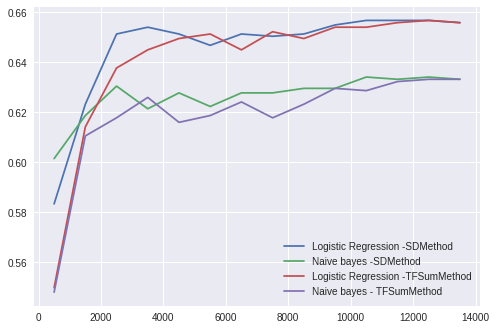

In [37]:
##Plot
import matplotlib.pyplot as plt
plt.plot(Nfeatures, LRacc1)
plt.plot(Nfeatures, NBacc1)
plt.plot(Nfeatures, LRacc2)
plt.plot(Nfeatures, NBacc2)
plt.legend(['Logistic Regression -SDMethod', 'Naive bayes -SDMethod', 'Logistic Regression -TFSumMethod', 'Naive bayes - TFSumMethod'], loc='best')

plt.show()

# Runtime - 1.1s

Best model appears to be logistic regression at around 10500 features using the SD feature reduction technique. Similarly the best Naive Bayes model is also at around 10500 features using the SD feature reduction technique. Thus, we will take the SD method as our preferred feature reduction. Furthermore, it seems our arbitrary number of 10000 features still works reasonably well for both models. As such, we will keep using the top 10000 features from SD method for our future models. Note that these accuracy scores are not cross validated and thus the optimum number of features may differ slightly from what is seen here. The reason cross validation was not performed in this grid search is because it would simply take too long (10 folds * 4 models * 14 iterations).



### Cross Validation of Multinomial Logistic Regression and Naive Bayes models

Explain the next steps

In [0]:
##Using StandardDeviation to get top 10000 features
FR = FeatureReduction(traindata, trainlabel)
idx = FR.StandardDeviationFR(nfeatures = 10000)
X = FR.transform(traindata)
Y = OneHotEncoding.transform(trainlabel)

In [39]:
cv_index = kfold_split(X, 10)
model = MultinomialLogisticRegression(lr=20, n_iter=40, C=0.001, SGD = True)
metrictable, accuracytable = cross_validation(X, Y, cv_index, model, 100, LR_get_accuracy)

# Runtime - 176.3s

Fold Number: 0
Fold Number: 1
Fold Number: 2
Fold Number: 3
Fold Number: 4
Fold Number: 5
Fold Number: 6
Fold Number: 7
Fold Number: 8
Fold Number: 9


In [45]:
##Naive Bayes
modelNB = MultinomialNaiveBayes(alpha=0.01, cv=0)
metrictableNB, accuracytableNB = cross_validation(X, trainlabel, cv_index, modelNB, 100, NB_get_accuracy, modeltype = 'NB')

# Runtime - 26.8s

Fold Number: 0
Fold Number: 1
Fold Number: 2
Fold Number: 3
Fold Number: 4
Fold Number: 5
Fold Number: 6
Fold Number: 7
Fold Number: 8
Fold Number: 9


The code below is for calculating the batch size for SGD, the overflow/index out of bounds error is more prominent in Colab

In [25]:
x = traindata.shape[0] - cv_index[0].shape[0]
print('Each fold will have:', traindata.shape[0] - cv_index[0].shape[0], 'training rows.')
print('Each fold will have:', cv_index[0].shape[0], 'test rows.')
for i in range(200, 2000):
  if x%i == 0:
    print('Batch size:', i, '\nNumber of rows per batch:', x/i)

Each fold will have: 18094 training rows.
Each fold will have: 2010 test rows.
Batch size: 218 
Number of rows per batch: 83.0


## **Ensembling Learning: 1. A simple ensemble model with cross validation folds** 

We will first perform a train-test split and then do cross validation splits on the training data. The data we will be using is the reduced dataset from Standard Deviation feature reduction (10000 columns). The test set will never be trained on. It will mimic a real test set scenario and will give us an indication of how the ensembled model will do on unseen data.

In [26]:
##Using StandardDeviation to get top 10000 features
FR = FeatureReduction(traindata, trainlabel)
idx = FR.StandardDeviationFR(nfeatures = 10000)
X = FR.transform(traindata)

##Dummy encode Y here for Logistic Regression later
y = OneHotEncoding.transform(trainlabel)
  
X_train, y_train, X_test, y_test = train_test_split(X, y, X_size = 19000)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Runtime - 2.4s

(19000, 10000)
(19000, 30)
(1104, 10000)
(1104, 30)


Now we create our cvsplit using the kfold_split function we created earlier.

In [27]:
cvsplit = kfold_split(X_train, k =10)
print(cvsplit.shape) ##These are the validation indices of the 10 fold cross validation

(10, 1900)


In [28]:
#### Time for Ensembling. We loop through the 10 folds and create a model for each one. We do predictions on both the validation and test dataset
##Outputs for the LR and NB models are saved from each fold
##This will take a while to run as we are creating 20 models in total. To reduce runtime, reduce the LR n_iter.
modelslr = []
modelsnb = []
lrvala = []
lrtestouts = []
lrtestaccs = []
nbvala = []
nbtestouts = []
nbtestaccs = []
for i, cv in enumerate(cvsplit):
    print('Fold', i+1)
    trainidx = list(set(list(range(0,19000)))-set(cv))
    ##Logistic Regression
    modellr = MultinomialLogisticRegression(lr = 20, n_iter = 40, C = 0.001 )
    modellr.fit(X_train[trainidx], y_train[trainidx], batchsize = 100)
    valout = modellr.predict(X_train[cv]) ##predicting on validation
    valacc = LR_get_accuracy(valout, y_train[cv])
    print('LRValAcc:', valacc)
    lrvala.append(valacc)
    testout = modellr.predict(X_test) ##predicting on test
    testacc = LR_get_accuracy(testout, y_test)
    print('LRTestAcc:', testacc)
    lrtestouts.append(testout)
    lrtestaccs.append(testacc)
    modelslr.append(modellr)
    ##Naive Bayes
    modelnb = MultinomialNaiveBayes(alpha=0.01, cv=0)
    modelnb.fit(X_train[trainidx], OneHotEncoding.inverse_transform(y_train[trainidx]), 
                X_train[cv], OneHotEncoding.inverse_transform(y_train[cv]), preload = False) ##Have to reverse dummy encode Y because naive bayes does not take dummies
    valoutnb = np.array(modelnb.predict()[1])
    valaccnb = NB_get_accuracy(valoutnb, OneHotEncoding.inverse_transform(y_train[cv]))
    nbvala.append(valaccnb)
    print('NBValAcc:', valaccnb)
    modelnb.fit(X_train[trainidx], OneHotEncoding.inverse_transform(y_train[trainidx]), X_test, OneHotEncoding.inverse_transform(y_test), preload = False)
    testoutnb = np.array(modelnb.predict()[1])
    testaccnb = NB_get_accuracy(testoutnb, OneHotEncoding.inverse_transform(y_test))
    print('NBTestAcc:', testaccnb)
    nbtestouts.append(testoutnb)
    nbtestaccs.append(testaccnb)
    modelsnb.append(modelnb)
    
# Runtime - 246.6s

Fold 1
LRValAcc: 0.6357894736842106
LRTestAcc: 0.657608695652174
NBValAcc: 0.6331578947368421
NBTestAcc: 0.6286231884057971
Fold 2
LRValAcc: 0.6494736842105263
LRTestAcc: 0.6467391304347826
NBValAcc: 0.6531578947368422
NBTestAcc: 0.6277173913043478
Fold 3
LRValAcc: 0.6626315789473685
LRTestAcc: 0.6594202898550725
NBValAcc: 0.6478947368421053
NBTestAcc: 0.6231884057971014
Fold 4
LRValAcc: 0.6426315789473684
LRTestAcc: 0.6476449275362319
NBValAcc: 0.621578947368421
NBTestAcc: 0.6277173913043478
Fold 5
LRValAcc: 0.6436842105263157
LRTestAcc: 0.6539855072463768
NBValAcc: 0.6331578947368421
NBTestAcc: 0.6222826086956522
Fold 6
LRValAcc: 0.64
LRTestAcc: 0.6512681159420289
NBValAcc: 0.6357894736842106
NBTestAcc: 0.6295289855072463
Fold 7
LRValAcc: 0.6521052631578947
LRTestAcc: 0.6539855072463768
NBValAcc: 0.6457894736842106
NBTestAcc: 0.6376811594202898
Fold 8
LRValAcc: 0.6463157894736842
LRTestAcc: 0.657608695652174
NBValAcc: 0.6378947368421053
NBTestAcc: 0.6259057971014492
Fold 9
LRValAcc: 

Now we ensemble the model. We will average the outputs for each model and take the probability that is the highest as the class. Since Naive Bayes does not return probability outputs we will apply the softmax function to it. This also makes it align with the Logistic regression output.

In [31]:
##Softmax function. Same as the one built in logistic regression class
def softmax(x):
    e_x = np.exp(x - np.max(x, axis = -1, keepdims= True))
    return e_x / np.sum(e_x, axis = -1, keepdims = True)
  
nboutssoftmaxed = [softmax(i) for i in nbtestouts]
nbensembleout = np.mean(nboutssoftmaxed, axis = 0)  
nbensembleacc = NB_get_accuracy(nbensembleout, OneHotEncoding.inverse_transform(y_test))

lrensembleout = np.mean(lrtestouts, axis = 0)
lrensembleacc = LR_get_accuracy(lrensembleout, y_test)

##We can have a look at the accuracy for just averaging across the model folds itself
print('Ensembled Logistic Regression Accuracy:', lrensembleacc)
print('Ensembled Naive Bayes Accuracy:', nbensembleacc)
##Both models seem to perform better when ensembled.
##Now we ensemble the two models together.

Ensemble = np.mean([lrensembleout, nbensembleout], axis = 0)
print('Ensembling both Logistic Regression and Naive Bayes Accuracy:', LR_get_accuracy(Ensemble, y_test))


Ensembled Logistic Regression Accuracy: 0.657608695652174
Ensembled Naive Bayes Accuracy: 0.634963768115942
Ensembling both Logistic Regression and Naive Bayes Accuracy: 0.6539855072463768


## Ensemble Learning: 2. Bagging

With bagging, we will sample from a subset of the data with replacement and train the model on these subsets.

In [0]:
""" a function to build index of subsets of data for bagging"""
def bootstrap_sample(nrow, sample_size, k = 30, random_state=0):
    # Set random Seed
    random.seed(random_state)
    # Return a list of k arrays of subset_index (sampling with replacement)
    bagging_index = np.random.choice(nrow, size=(k, sample_size), replace=True)
    return bagging_index

In [14]:
##Using StandardDeviation to get top 10000 features
FR = FeatureReduction(traindata, trainlabel)
idx = FR.StandardDeviationFR(nfeatures = 10000)
X = FR.transform(traindata)

##Dummy encode Y here for Logistic Regression later
y = OneHotEncoding.transform(trainlabel)
  
X_train, y_train, X_val, y_val = train_test_split(X, y, X_size = 19000)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(19000, 10000)
(19000, 30)
(1104, 10000)
(1104, 30)


In [22]:
split = bootstrap_sample(19000, 10000, k = 20)
print(split.shape) 

(20, 10000)


In [23]:
np.random.seed(1)

##Validation data that we leave out 
lrvalouts = []
lrvalaccs = []
nbvalouts = []
nbvalaccs = []

for i, cv in enumerate(split):
    print('Fold', i+1)
    ##Logistic Regression
    modellr = MultinomialLogisticRegression(lr = 20, n_iter = 40, C = 0.001 )
    modellr.fit(X_train[cv], y_train[cv], batchsize = 100)
    valoutlr = modellr.predict(X_val) ##predicting on test
    valacclr = LR_get_accuracy(valoutlr, y_val)
    print('LRValAcc:', valacclr)
    lrvalouts.append(valoutlr)
    lrvalaccs.append(valacclr)
    ##Naive Bayes
    modelnb = MultinomialNaiveBayes(alpha=0.01, cv=0)
    modelnb.fit(X_train[cv], OneHotEncoding.inverse_transform(y_train[cv]), X_val, OneHotEncoding.inverse_transform(y_val), preload = False)
    valoutnb = np.array(modelnb.predict()[1])
    valaccnb = NB_get_accuracy(valoutnb, OneHotEncoding.inverse_transform(y_val))
    print('NBValAcc:', valaccnb)
    nbvalouts.append(valoutnb)
    nbvalaccs.append(valaccnb)

Fold 1
LRValAcc: 0.6340579710144928
NBValAcc: 0.6086956521739131
Fold 2
LRValAcc: 0.6304347826086957
NBValAcc: 0.6014492753623188
Fold 3
LRValAcc: 0.6322463768115942
NBValAcc: 0.6041666666666666
Fold 4
LRValAcc: 0.6259057971014492
NBValAcc: 0.6077898550724637
Fold 5
LRValAcc: 0.6231884057971014
NBValAcc: 0.595108695652174
Fold 6
LRValAcc: 0.6240942028985508
NBValAcc: 0.6014492753623188
Fold 7
LRValAcc: 0.6385869565217391
NBValAcc: 0.6105072463768116
Fold 8
LRValAcc: 0.6322463768115942
NBValAcc: 0.5942028985507246
Fold 9
LRValAcc: 0.6458333333333334
NBValAcc: 0.6195652173913043
Fold 10
LRValAcc: 0.6259057971014492
NBValAcc: 0.6068840579710145
Fold 11
LRValAcc: 0.6304347826086957
NBValAcc: 0.6032608695652174
Fold 12
LRValAcc: 0.6141304347826086
NBValAcc: 0.595108695652174
Fold 13
LRValAcc: 0.6268115942028986
NBValAcc: 0.6059782608695652
Fold 14
LRValAcc: 0.6331521739130435
NBValAcc: 0.6059782608695652
Fold 15
LRValAcc: 0.6413043478260869
NBValAcc: 0.6096014492753623
Fold 16
LRValAcc: 0.6

In [24]:
##Softmax function. Same as the one built in logistic regression class
def softmax(x):
    e_x = np.exp(x - np.max(x, axis = -1, keepdims= True))
    return e_x / np.sum(e_x, axis = -1, keepdims = True)
  
nboutssoftmaxed = [softmax(i) for i in nbvalouts]
nbensembleout = np.mean(nboutssoftmaxed, axis = 0)  
nbensembleacc = NB_get_accuracy(nbensembleout, OneHotEncoding.inverse_transform(y_val))

lrensembleout = np.mean(lrvalouts, axis = 0)
lrensembleacc = LR_get_accuracy(lrensembleout, y_val)

##We can have a look at the accuracy for just averaging across the model folds itself
print('Ensembled Logistic Regression Accuracy:', lrensembleacc)
print('Ensembled Naive Bayes Accuracy:', nbensembleacc)
##Both models seem to perform better when ensembled.
##Now we ensemble the two models together.

Ensemble = np.mean([lrensembleout, nbensembleout], axis = 0)
print('Ensembling both Logistic Regression and Naive Bayes Accuracy:', LR_get_accuracy(Ensemble, y_val))



0.6730072463768116 0.6376811594202898
0.6539855072463768


## Code to run the model on test data. We will use the same bagging model but with larger bag sizes (10000 sample size > 19000 sample size).

In [26]:
##Using StandardDeviation to get top 10000 features
FR = FeatureReduction(traindata, trainlabel)
idx = FR.StandardDeviationFR(nfeatures = 10000)
X = FR.transform(traindata)

##Dummy encode Y here for Logistic Regression later
y = OneHotEncoding.transform(trainlabel)
  
X_train, y_train, X_val, y_val = train_test_split(X, y, X_size = 19000)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(19000, 10000)
(19000, 30)
(1104, 10000)
(1104, 30)


In [0]:
test_data_downloaded = drive.CreateFile({'id': '1y_YySFyibYYwQtJr6v7Qf81FqULwK7Fk'})
test_data_downloaded.GetContentFile('test_data.csv') 

In [28]:
test = csr_matrix(pd.read_csv('test_data.csv', header = None).drop(0,1))

##We must transform the test data with the same feature reduction we used in train.
test = FR.transform(test)
print(test.shape)

(2233, 10000)


In [29]:
split = bootstrap_sample(19000, 19000, k = 20)
print(split.shape) ##We will make 20 splits. I.e. 40 models total

(20, 19000)


In [31]:

np.random.seed(1)

##Validation data that we leave out 
lrvalouts = []
lrvalaccs = []
nbvalouts = []
nbvalaccs = []

##Actual test predictions
lrtestout = []
nbtestout = []

for i, cv in enumerate(split):
    print('Fold', i+1)
    ##Logistic Regression
    modellr = MultinomialLogisticRegression(lr = 20, n_iter = 40, C = 0.001 )
    modellr.fit(X_train[cv], y_train[cv], batchsize = 100)
    valoutlr = modellr.predict(X_val) ##predicting on test
    valacclr = LR_get_accuracy(valoutlr, y_val)
    print('LRValAcc:', valacclr)
    lrvalouts.append(valoutlr)
    lrvalaccs.append(valacclr)
    ##Naive Bayes
    modelnb = MultinomialNaiveBayes(alpha=0.01, cv=0)
    modelnb.fit(X_train[cv], OneHotEncoding.inverse_transform(y_train[cv]), X_val, OneHotEncoding.inverse_transform(y_val), preload = False)
    valoutnb = np.array(modelnb.predict()[1])
    valaccnb = NB_get_accuracy(valoutnb, OneHotEncoding.inverse_transform(y_val))
    print('NBValAcc:', valaccnb)
    nbvalouts.append(valoutnb)
    nbvalaccs.append(valaccnb)
    ##Predict on test data
    testoutlr = modellr.predict(test)
    modelnb.fit(X_train[cv], OneHotEncoding.inverse_transform(y_train[cv]), test, preload = False)
    testoutnb = np.array(modelnb.predict()[1])
    lrtestout.append(testoutlr)
    nbtestout.append(testoutnb)


Fold 1
LRValAcc: 0.6612318840579711
NBValAcc: 0.6231884057971014
Fold 2
LRValAcc: 0.6394927536231884
NBValAcc: 0.6240942028985508
Fold 3
LRValAcc: 0.6485507246376812
NBValAcc: 0.6123188405797102
Fold 4
LRValAcc: 0.6431159420289855
NBValAcc: 0.6177536231884058
Fold 5
LRValAcc: 0.6503623188405797
NBValAcc: 0.6231884057971014
Fold 6
LRValAcc: 0.6376811594202898
NBValAcc: 0.6086956521739131
Fold 7
LRValAcc: 0.6485507246376812
NBValAcc: 0.6240942028985508
Fold 8
LRValAcc: 0.654891304347826
NBValAcc: 0.6195652173913043
Fold 9
LRValAcc: 0.6440217391304348
NBValAcc: 0.615036231884058
Fold 10
LRValAcc: 0.644927536231884
NBValAcc: 0.6014492753623188
Fold 11
LRValAcc: 0.6295289855072463
NBValAcc: 0.6268115942028986
Fold 12
LRValAcc: 0.6476449275362319
NBValAcc: 0.6132246376811594
Fold 13
LRValAcc: 0.6585144927536232
NBValAcc: 0.6168478260869565
Fold 14
LRValAcc: 0.6431159420289855
NBValAcc: 0.6168478260869565
Fold 15
LRValAcc: 0.6376811594202898
NBValAcc: 0.6123188405797102
Fold 16
LRValAcc: 0.64

In [36]:
##Softmax function. Same as the one built in logistic regression class
def softmax(x):
    e_x = np.exp(x - np.max(x, axis = -1, keepdims= True))
    return e_x / np.sum(e_x, axis = -1, keepdims = True)
  
nboutssoftmaxed = [softmax(i) for i in nbvalouts]
nbensembleout = np.mean(nboutssoftmaxed, axis = 0)  
nbensembleacc = NB_get_accuracy(nbensembleout, OneHotEncoding.inverse_transform(y_val))

lrensembleout = np.mean(lrvalouts, axis = 0)
lrensembleacc = LR_get_accuracy(lrensembleout, y_val)

##We can have a look at the accuracy for just averaging across the model folds itself
print('Ensembled Logistic Regression Accuracy:', lrensembleacc)
print('Ensembled Naive Bayes Accuracy:', nbensembleacc)
##Both models seem to perform better when ensembled.
##Now we ensemble the two models together.

Ensemble = np.mean([lrensembleout, nbensembleout], axis = 0)
print('Ensembling both Logistic Regression and Naive Bayes Accuracy:', LR_get_accuracy(Ensemble, y_val))


Ensembled Logistic Regression Accuracy: 0.6702898550724637
Ensembled Naive Bayes Accuracy: 0.6313405797101449
Ensembling both Logistic Regression and Naive Bayes Accuracy: 0.6512681159420289


In [103]:
lrtestensemble = np.mean(lrtestout, axis = 0)

nbtestsoftmax = [softmax(i) for i in nbtestout]
nbtestensemble = np.mean(nbtestsoftmax, axis = 0)

testEnsemble = np.mean([lrtestensemble, nbtestensemble], axis = 0)

##Choose which prediction to use for submission
testpred = np.argmax(lrtestensemble, axis = 1)
#testpred = np.argmax(testEnsemble, axis = 1)
testpred.shape


(2233,)

In [0]:
#del test
submissionfile = pd.read_csv('test_data.csv', header = None)[0]
submissionfile = pd.concat([submissionfile, pd.Series(testpred)], axis = 1)
print(submissionfile.head())

#submissionfile.to_csv('predicted_labels.csv', index = False)

### Accuracy

The metrics below were calculated using a 10-fold cross validation and compares the results of the Logistic Regression and Naive Bayes models. The models were both trained using the same train and test splits and used the first 10,000 features provided by the maximum standard deviation pre-processing method.

The Logistic Regression model outperformed the Naive Bayes model with respective weighted averages of 0.65 and 0.63. The Logistic Regression also outperformed the Naive Bayes when comparing micro-averaged precision, recall and F-score.

The models were also analysed on their respective performance at the categorical level. The models both struggled with the 'Lifestyle' and 'Entertainment' labels, both models producing in F-scores lower than 0.35. Moreover, both models had very low recall values for the 'Lifestyle' label, this suggests that the label was rarely selected. The frequency at which 'Lifestyle' was predicted is interesting as the distribution of classes is not equal in the task, and despite being one of the more populous classes it was predicted at the lowest relative rate. The consistency between both models in predicting the 'Lifestyle' and 'Entertainment' categories suggests that the class itself is difficult to classify using a bag of words representation. In contrast, both models performed well on the 'Weather' and 'Cards and Casino' categories, once again the similar results suggest that the metrics may rely more on the feature representation and class label rather than the applied machine learning algorithm.

There was little difference between the micro and macro averages for the metrics, this is likely due to insubstantial asymmetric distribution of the class labels.


In [21]:
metrictable = metrictable.groupby('Label').mean() 
metrictable.index = pd.Series(labels)
print(metrictable)

                     Count  Accuracy  Precision    Recall   F-Score
Arcade and Action     67.1  0.641441   0.544060  0.641441  0.586827
Books and Reference   73.0  0.646196   0.581411  0.646196  0.609290
Brain and Puzzle      69.9  0.712926   0.654115  0.712926  0.680246
Business              68.4  0.565206   0.615168  0.565206  0.586850
Cards and Casino      70.3  0.898949   0.884778  0.898949  0.890069
Casual                72.6  0.486089   0.524277  0.486089  0.502408
Comics                35.9  0.443266   0.779967  0.443266  0.556765
Communication         71.6  0.664749   0.560775  0.664749  0.607100
Education             74.3  0.641221   0.665332  0.641221  0.651417
Entertainment         69.2  0.381794   0.365002  0.381794  0.371423
Finance               70.2  0.865184   0.803803  0.865184  0.831939
Health and Fitness    76.6  0.758908   0.679753  0.758908  0.716811
Libraries and Demo    47.9  0.507541   0.742302  0.507541  0.601677
Lifestyle             72.6  0.280538   0.432320 

In [48]:
metrictableNB = metrictableNB.groupby('Label').mean() 
metrictableNB.index = pd.Series(labels)
print(metrictableNB)

                     Count  Accuracy  Precision    Recall   F-Score
Arcade and Action     67.0  0.675102   0.523550  0.675102  0.587909
Books and Reference   73.0  0.555424   0.600841  0.555424  0.575890
Brain and Puzzle      69.9  0.696042   0.645307  0.696042  0.668137
Business              68.4  0.543849   0.558600  0.543849  0.548368
Cards and Casino      70.3  0.885160   0.903173  0.885160  0.893244
Casual                72.5  0.486196   0.497427  0.486196  0.489740
Comics                35.9  0.370241   0.765843  0.370241  0.495745
Communication         71.6  0.587819   0.556519  0.587819  0.570485
Education             74.3  0.665447   0.633244  0.665447  0.645095
Entertainment         69.2  0.328408   0.396962  0.328408  0.355330
Finance               70.2  0.861855   0.808935  0.861855  0.832752
Health and Fitness    76.6  0.747486   0.705226  0.747486  0.723068
Libraries and Demo    47.9  0.410955   0.864895  0.410955  0.549942
Lifestyle             72.6  0.267394   0.417765 

In [23]:
print('Micro Average - Logistic Regression:')
print(np.mean(metrictable, axis=0))
print(np.mean(accuracytable, axis=0))

Micro Average:
Count        67.000000
Accuracy      0.650543
Precision     0.665680
Recall        0.650543
F-Score       0.650780
dtype: float64
0.653681592039801


In [64]:
print('Micro Average - Naive Bayes:')
print(np.mean(metrictableNB, axis=0))
print(np.mean(accuracytableNB, axis=0))

Micro Average - Naive Bayes:
Count        67.000000
Accuracy      0.633524
Precision     0.651337
Recall        0.633524
F-Score       0.632494
dtype: float64
0.6372636815920398


In [26]:
metrictable['Weighted Accuracy'] = metrictable['Count'] * metrictable['Accuracy']
metrictable['Weighted Precision'] = metrictable['Count'] * metrictable['Precision']
metrictable['Weighted Recall'] = metrictable['Count'] * metrictable['Recall']
metrictable['Weighted F-Score'] = metrictable['Count'] * metrictable['F-Score']

print('Micro Average:')
print(np.sum(metrictable[['Weighted Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F-Score']], axis=0)/2010)

Micro Average:
Weighted Accuracy     0.653756
Weighted Precision    0.657704
Weighted Recall       0.653756
Weighted F-Score      0.649558
dtype: float64


## Extensive Analysis



The plot below shows how each model's accuracy is effected by introducing new feautres, the plot compares the rate of learning between two of our pre-processing feature selection methods. The plot shows that the standard deviation method outperforms the TF-IDF for both models. The models are able to learn with less features using the standard deviation method, they are able to exceed the maximum accuracy of the TF-IDF method with only 2500 (~20%) of the available features.

The difference in performance between the two models is likely attributable to nature of a topic classification task. Models tend to learn to differentiation between topics or groups by learning which words appear at a disproportionate level in one class compared to others. Therefore, as opposed to summing the values per word and choosing the most frequent column, the standard deviation prioritises words which can be used to separate classes.

In addition to comparing the pre-processing methods, the plot allows us to analyse an optimal cut-off for the model complexity. Given that the logistic regression model can run a 10-fold cross validation with 10,000 features in 3 minutes, the duration of the model is less of a concern. However, if applying the same model to a larger dataset we could consider changing the complexity of the model. Moreover, analysis of the model's complexity is also important in reducing the model's propensity to over fit.


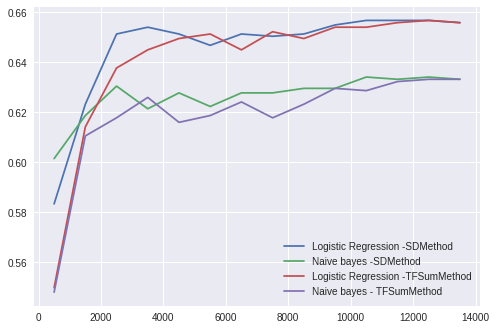

In [29]:
##Plot
import matplotlib.pyplot as plt
plt.plot(Nfeatures, LRacc1)
plt.plot(Nfeatures, NBacc1)
plt.plot(Nfeatures, LRacc2)
plt.plot(Nfeatures, NBacc2)
plt.legend(['Logistic Regression -SDMethod', 'Naive bayes -SDMethod', 'Logistic Regression -TFSumMethod', 'Naive bayes - TFSumMethod'], loc='best')

plt.show()

# Runtime - 1.1s

The difference in accuracy between 3500 features and 10500 features seems to be negligible when using logistic regression. As we prefer to always use fewer features, we will run a cross validation of the logistic regression model on the top 3500 features from the SD method.

In [0]:
##Using StandardDeviation to get top 3500 features
FR = FeatureReduction(traindata, trainlabel)
idx = FR.StandardDeviationFR(nfeatures = 3500)
X = FR.transform(traindata)
Y = OneHotEncoding.transform(trainlabel)

In [58]:
cv_index = kfold_split(X, 10)
model = MultinomialLogisticRegression(lr=15, n_iter=40, C=0.001, SGD = True)
metrictable, accuracytable = cross_validation(X, Y, cv_index, model, 100, LR_get_accuracy)

# Runtime - 176.3s

Fold Number: 0
Fold Number: 1
Fold Number: 2
Fold Number: 3
Fold Number: 4
Fold Number: 5
Fold Number: 6
Fold Number: 7
Fold Number: 8
Fold Number: 9


In [59]:
metrictable = metrictable.groupby('Label').mean() 
metrictable.index = pd.Series(labels)
print(metrictable)

                     Count  Accuracy  Precision    Recall   F-Score
Arcade and Action     67.1  0.665752   0.548468  0.665752  0.600007
Books and Reference   73.0  0.634280   0.560733  0.634280  0.593893
Brain and Puzzle      69.9  0.715489   0.675078  0.715489  0.694061
Business              68.3  0.564644   0.596143  0.564644  0.579263
Cards and Casino      70.3  0.893854   0.865198  0.893854  0.878640
Casual                72.6  0.504758   0.552735  0.504758  0.525856
Comics                35.9  0.419912   0.773731  0.419912  0.541759
Communication         71.6  0.676222   0.548767  0.676222  0.605307
Education             74.3  0.606752   0.648747  0.606752  0.626609
Entertainment         69.0  0.391089   0.381139  0.391089  0.383353
Finance               70.2  0.875931   0.782380  0.875931  0.825746
Health and Fitness    76.6  0.741524   0.676864  0.741524  0.707132
Libraries and Demo    47.8  0.512422   0.748644  0.512422  0.603770
Lifestyle             72.6  0.294378   0.444778 

In [60]:
metrictable['Weighted Accuracy'] = metrictable['Count'] * metrictable['Accuracy']
metrictable['Weighted Precision'] = metrictable['Count'] * metrictable['Precision']
metrictable['Weighted Recall'] = metrictable['Count'] * metrictable['Recall']
metrictable['Weighted F-Score'] = metrictable['Count'] * metrictable['F-Score']

print('Micro Average:')
print(np.sum(metrictable[['Weighted Accuracy', 'Weighted Precision', 'Weighted Recall', 'Weighted F-Score']], axis=0)/2010)

Micro Average:
Weighted Accuracy     0.653005
Weighted Precision    0.656069
Weighted Recall       0.653005
Weighted F-Score      0.648500
dtype: float64


Given that the performance of the 3500 features model is only a little bit worse than the 10000 features model, we can try our bagging on the training data with 3500 features and examine our performance.

In [19]:
##Using StandardDeviation to get top 3500 features
FR = FeatureReduction(traindata, trainlabel)
idx = FR.StandardDeviationFR(nfeatures = 3500)
X = FR.transform(traindata)

##Dummy encode Y here for Logistic Regression later
y = OneHotEncoding.transform(trainlabel)
  
X_train, y_train, X_val, y_val = train_test_split(X, y, X_size = 19000)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

split = bootstrap_sample(19000, 19000, k = 20)
print(split.shape) ##We will make 20 splits. I.e. 40 models total

(19000, 3500)
(19000, 30)
(1104, 3500)
(1104, 30)
(20, 19000)


In [0]:
test_data_downloaded = drive.CreateFile({'id': '1y_YySFyibYYwQtJr6v7Qf81FqULwK7Fk'})
test_data_downloaded.GetContentFile('test_data.csv') 

In [21]:
test = csr_matrix(pd.read_csv('test_data.csv', header = None).drop(0,1))

##We must transform the test data with the same feature reduction we used in train.
test = FR.transform(test)
print(test.shape)

(2233, 3500)


In [22]:
np.random.seed(1)

##Validation data that we leave out 
lrvalouts = []
lrvalaccs = []
nbvalouts = []
nbvalaccs = []

##Actual test predictions
lrtestout = []
nbtestout = []

for i, cv in enumerate(split):
    print('Fold', i+1)
    ##Logistic Regression
    modellr = MultinomialLogisticRegression(lr = 20, n_iter = 40, C = 0.001 )
    modellr.fit(X_train[cv], y_train[cv], batchsize = 100)
    valoutlr = modellr.predict(X_val) ##predicting on test
    valacclr = LR_get_accuracy(valoutlr, y_val)
    print('LRValAcc:', valacclr)
    lrvalouts.append(valoutlr)
    lrvalaccs.append(valacclr)
    ##Naive Bayes
    modelnb = MultinomialNaiveBayes(alpha=0.01, cv=0)
    modelnb.fit(X_train[cv], OneHotEncoding.inverse_transform(y_train[cv]), X_val, OneHotEncoding.inverse_transform(y_val), preload = False)
    valoutnb = np.array(modelnb.predict()[1])
    valaccnb = NB_get_accuracy(valoutnb, OneHotEncoding.inverse_transform(y_val))
    print('NBValAcc:', valaccnb)
    nbvalouts.append(valoutnb)
    nbvalaccs.append(valaccnb)
    ##Predict on test data
    testoutlr = modellr.predict(test)
    modelnb.fit(X_train[cv], OneHotEncoding.inverse_transform(y_train[cv]), test, preload = False)
    testoutnb = np.array(modelnb.predict()[1])
    lrtestout.append(testoutlr)
    nbtestout.append(testoutnb)


Fold 1
LRValAcc: 0.644927536231884
NBValAcc: 0.6268115942028986
Fold 2
LRValAcc: 0.6358695652173914
NBValAcc: 0.6123188405797102
Fold 3
LRValAcc: 0.6286231884057971
NBValAcc: 0.6240942028985508
Fold 4
LRValAcc: 0.6494565217391305
NBValAcc: 0.625
Fold 5
LRValAcc: 0.634963768115942
NBValAcc: 0.6114130434782609
Fold 6
LRValAcc: 0.6286231884057971
NBValAcc: 0.615036231884058
Fold 7
LRValAcc: 0.634963768115942
NBValAcc: 0.6132246376811594
Fold 8
LRValAcc: 0.6394927536231884
NBValAcc: 0.6168478260869565
Fold 9
LRValAcc: 0.6403985507246377
NBValAcc: 0.6123188405797102
Fold 10
LRValAcc: 0.6331521739130435
NBValAcc: 0.6105072463768116
Fold 11
LRValAcc: 0.6367753623188406
NBValAcc: 0.6195652173913043
Fold 12
LRValAcc: 0.6485507246376812
NBValAcc: 0.6277173913043478
Fold 13
LRValAcc: 0.6585144927536232
NBValAcc: 0.6204710144927537
Fold 14
LRValAcc: 0.6177536231884058
NBValAcc: 0.6105072463768116
Fold 15
LRValAcc: 0.6385869565217391
NBValAcc: 0.6159420289855072
Fold 16
LRValAcc: 0.634963768115942


In [23]:
##Softmax function. Same as the one built in logistic regression class
def softmax(x):
    e_x = np.exp(x - np.max(x, axis = -1, keepdims= True))
    return e_x / np.sum(e_x, axis = -1, keepdims = True)
  
nboutssoftmaxed = [softmax(i) for i in nbvalouts]
nbensembleout = np.mean(nboutssoftmaxed, axis = 0)  
nbensembleacc = NB_get_accuracy(nbensembleout, OneHotEncoding.inverse_transform(y_val))

lrensembleout = np.mean(lrvalouts, axis = 0)
lrensembleacc = LR_get_accuracy(lrensembleout, y_val)

##We can have a look at the accuracy for just averaging across the model folds itself
print('Ensembled Logistic Regression Accuracy:', lrensembleacc)
print('Ensembled Naive Bayes Accuracy:', nbensembleacc)
##Both models seem to perform better when ensembled.
##Now we ensemble the two models together.

Ensemble = np.mean([lrensembleout, nbensembleout], axis = 0)
print('Ensembling both Logistic Regression and Naive Bayes Accuracy:', LR_get_accuracy(Ensemble, y_val))


Ensembled Logistic Regression Accuracy: 0.6657608695652174
Ensembled Naive Bayes Accuracy: 0.6177536231884058
Ensembling both Logistic Regression and Naive Bayes Accuracy: 0.6621376811594203


**Now we can create our test predictions**

Although the ensembling of both logistic regression and naive bayes may improve the overall accuracy in certain scenarios, in most cases the ensembled logistic regression performs the best. As such, we will take the ensembled logistic regression output as the final prediction.

In [24]:
lrtestensemble = np.mean(lrtestout, axis = 0)

nbtestsoftmax = [softmax(i) for i in nbtestout]
nbtestensemble = np.mean(nbtestsoftmax, axis = 0)

testEnsemble = np.mean([lrtestensemble, nbtestensemble], axis = 0)

##Choose which prediction to use for submission
testpred = np.argmax(lrtestensemble, axis = 1) ##Only logistic regression
#testpred = np.argmax(testEnsemble, axis = 1) ##Ensembled Logistic Regression and Naive Bayes
print(testpred.shape)
print(test.shape)


(2233,)
(2233, 3500)


In [0]:
Labels = pd.DataFrame(labels)

In [37]:
testpred
testpredlabels = []
for i in testpred:
  testpredlabels.append(labels[i])
  
print(testpredlabels)

['Brain and Puzzle', 'Travel and Local', 'Productivity', 'Health and Fitness', 'Books and Reference', 'Communication', 'Entertainment', 'Transportation', 'Casual', 'Productivity', 'Health and Fitness', 'Books and Reference', 'Transportation', 'Casual', 'Business', 'Books and Reference', 'Communication', 'Books and Reference', 'Books and Reference', 'Health and Fitness', 'Libraries and Demo', 'Media and Video', 'Shopping', 'Cards and Casino', 'Shopping', 'Brain and Puzzle', 'Shopping', 'Books and Reference', 'Books and Reference', 'Finance', 'Communication', 'Photography', 'Cards and Casino', 'Racing', 'Books and Reference', 'Casual', 'Media and Video', 'Cards and Casino', 'Music and Audio', 'Transportation', 'Tools', 'Travel and Local', 'Entertainment', 'Casual', 'Personalization', 'Arcade and Action', 'Comics', 'Photography', 'Shopping', 'Education', 'Health and Fitness', 'Social', 'Social', 'Brain and Puzzle', 'Productivity', 'Brain and Puzzle', 'Arcade and Action', 'Weather', 'Trave

In [38]:
#output test data prediction
submissionfile = pd.read_csv('test_data.csv', header = None)[0]
submissionfile = pd.concat([submissionfile, pd.Series(testpredlabels)], axis = 1)
print(submissionfile.head())
submissionfile.to_csv('predicted_labels.csv', index = False)

                                      0                    0
0  dalmax.games.turnBasedGames.connect4     Brain and Puzzle
1          com.holfeld.japaneseplusfree     Travel and Local
2              com.mobileApp.controller         Productivity
3      com.aarontennyson.calorietracker   Health and Fitness
4  com.totaldevel.android.todocitas.ads  Books and Reference


In [39]:
#del test
submissionfile = pd.read_csv('test_data.csv', header = None)[0]
submissionfile = pd.concat([submissionfile, pd.Series(testpredlabels)], axis = 1)
print(submissionfile.head())

submissionfile.to_csv('predicted_labels.csv', index = False)

export_csv = submissionfile.to_csv('predicted_labels.csv')

uploaded = drive.CreateFile({'title': 'predicted_labels.csv'})
uploaded.SetContentFile('predicted_labels.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

                                      0                    0
0  dalmax.games.turnBasedGames.connect4     Brain and Puzzle
1          com.holfeld.japaneseplusfree     Travel and Local
2              com.mobileApp.controller         Productivity
3      com.aarontennyson.calorietracker   Health and Fitness
4  com.totaldevel.android.todocitas.ads  Books and Reference
Uploaded file with ID 1kAjvNj-cfJEveRGppoyuLUigMddClZnx


The experiment result shows that logistic regression gives higher accuracy than naive bayes in general. One of the possible reasons why logistic regression is outperforming naive bayes is that logistic regression assumes a linear relationship between all dependent and independent variables. This assumption preserves the relative influence between different words while naive bayes ignore it by assumping the occurences of words are independent events. 

Another pattern we can see from our experiment result is that ensemble model outperforms individual classifier in general. This further proves our research findings that ensemble model usually gives higher accuracy and lower variance on the prediction results. The stronger classifier within the ensemble model can usually drag up the result of the weaker classifier, and thus achieves better model. And in the bagging case, the permutation of the training data can potentially generate new information for the classifier to learn. However, it is not alway the case that ensemble will perform better. In the ensemble model with both naive bayes classfiers and logistic regression classifers, the naive bayes classfier drag down the performance of logistic regression. Thus, it is also important to choose the best base models before building an emsemble.

Results for both the 'Lifestyle' and 'Entertainment' labels were bad for both models, with F-scores lower than 0.35. Moreover, both models had very low recall values for the 'Lifestyle' label, suggesting that the label was rarely selected. The consistency between both models in predicting the 'Lifestyle' and 'Entertainment' categories suggests that the class itself is difficult to classify using a bag of words representation. 









list of references

1. Dietterich, T. G. (2000, June). Ensemble methods in machine learning. In International workshop on multiple classifier systems (pp. 1-15). Springer, Berlin, Heidelberg.
2. Lewis, D. D. (1998, April). Naive (Bayes) at forty: The independence assumption in information retrieval. In European conference on machine learning (pp. 4-15). Springer, Berlin, Heidelberg.  
3. Martin, J. H., & Jurafsky, D. (2009). Speech and language processing: An introduction to natural language processing, computational linguistics, and speech recognition. Pearson/Prentice Hall.
4. Opitz, D., & Maclin, R. (1999). Popular ensemble methods: An empirical study. Journal of artificial intelligence research, 11, 169-198.
5. Rennie, J. D., Shih, L., Teevan, J., & Karger, D. R. (2003). Tackling the poor assumptions of naive bayes text classifiers. In Proceedings of the 20th international conference on machine learning (ICML-03) (pp. 616-623).
6. Russell, S. J., & Norvig, P. (2016). Artificial intelligence: a modern approach. Malaysia; Pearson Education Limited,.
7. Schütze, H., Manning, C. D., & Raghavan, P. (2008). Introduction to information retrieval (Vol. 39). Cambridge University Press.
8. Smolyakov, V. (2017). Ensemble Learning to Improve Machine Learning Results. Retrieved from: https://blog.statsbot.co/ensemble-learning-d1dcd548e936 
9. Vryniotis , V. (2013). Machine Learning Tutorial: The Multinomial Logistic Regression (Softmax Regression). Retrieved from: http://blog.datumbox.com/machine-learning-tutorial-the-multinomial-logistic-regression-softmax-regression/
10. Winston, P. (2010). Learning: Boosting [Video file]. Retrieved from: https://www.youtube.com/watch?v=UHBmv7qCey4#t=48m38s 